# DAM202 Assignment – Embeddings & Evaluation

## 1. Environment Setup
- Installs required libraries (`gensim`, `scikit-learn`, `pandas`, `nltk`, `tqdm`, `wget`).
- Imports necessary modules.
- Sets random seeds for reproducibility.
- Creates a working directory in Google Drive.


In [19]:
# Run this cell first (Colab)
!pip install --upgrade gensim==4.3.3 scikit-learn pandas nltk tqdm wget
# Optional: for glove training (if you want to run GloVe locally)


import os
import re
import json
import random
from pathlib import Path
from collections import Counter


import numpy as np
import pandas as pd
from tqdm.auto import tqdm


import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')


from gensim.models import Word2Vec, FastText
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report


# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


# Working folder (in Colab you can mount Drive; here we write to local filesystem)
WORKDIR = '/content/drive/MyDrive/DAM202_embeddings'
os.makedirs(WORKDIR, exist_ok=True)
print('Workdir:', WORKDIR)

Workdir: /content/drive/MyDrive/DAM202_embeddings


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Google Drive Mounting
- Mounts Google Drive to access datasets and save models in Colab.
- Sets the working directory path accordingly.

In [20]:
from google.colab import drive
drive.mount('/content/drive')
# then set WORKDIR = '/content/drive/MyDrive/DAM202_embeddings'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Dataset Loading
- Loads the phishing email dataset (`phishing_email.csv`) into a Pandas DataFrame.
- Displays available columns and the first few rows.


In [21]:
DATA_PATH = '/content/drive/MyDrive/DAM202_embeddings/phishing_email.csv' # adjust if different in Colab
assert os.path.exists(DATA_PATH), f"Data file not found at {DATA_PATH}"


df = pd.read_csv(DATA_PATH)
print('Columns:', df.columns.tolist())
df.head()

Columns: ['text_combined', 'label']


,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('text_combined').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('label', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text_combined')):
  _plot_series(series, series_name, i)
  fig.legend(title='text_combined', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

## 4. Label Column Setup
- Defines the label column in the dataset (phishing vs. non-phishing).
- Ensures correct target assignment for later training.

In [22]:
# Set label column name (change if your CSV uses something else)
LABEL_COL = 'label' if 'label' in df.columns else 'is_phishing' if 'is_phishing' in df.columns else None
print('Detected label column:', LABEL_COL)


# If user has no label, we'll proceed but extrinsic eval will need manual labels.
if LABEL_COL is None:
    print('\nWARNING: no label column detected. Extrinsic evaluation (classification) requires labels.\n')

Detected label column: label


## 5. Data Exploration
- Performs initial exploration of dataset structure and content.
- Identifies text and label distributions.

In [23]:
print('Total rows:', len(df))
print(df[LABEL_COL].value_counts(dropna=False) if LABEL_COL else 'no label')

Total rows: 82486
label
1    42891
0    39595
Name: count, dtype: int64


## 6. Text Preprocessing
- Defines cleaning and preprocessing functions (removing special characters, lowercasing, tokenizing).
- Applies `nltk` tokenization and prepares clean text data.

In [24]:
URL_RE = re.compile(r"https?://\S+|www\.\S+")
EMAIL_RE = re.compile(r"\b[\w.%-]+@[\w.-]+\.[A-Za-z]{2,}\b")
HTML_RE = re.compile(r'<[^>]+>')
NON_PRINT_RE = re.compile(r'[^\x00-\x7f]')


def preprocess_text(text, keep_urls=True, normalize_numbers=True):
    if not isinstance(text, str):
        return ''
    text = text.strip()
    text = HTML_RE.sub(' ', text)
    text = NON_PRINT_RE.sub(' ', text)
    # preserve URLs or replace with a token
    if keep_urls:
        urls = URL_RE.findall(text)
        # optionally replace full urls by token or keep raw: we keep a placeholder but preserve domain parsing later
        text = URL_RE.sub(' <URL> ', text)
    else:
        text = URL_RE.sub(' ', text)


    # preserve email addresses
    text = EMAIL_RE.sub(' <EMAIL> ', text)


    # normalize numbers
    if normalize_numbers:
        text = re.sub(r'\b\d+(?:[\.,]\d+)?\b', ' <NUM> ', text)


    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text


# Apply preprocessing to a text column (detect first textual column automatically)
TEXT_COL = None
for c in df.columns:
    if df[c].dtype == object:
        TEXT_COL = c
        break


assert TEXT_COL is not None, 'No text column detected in CSV'
print('Detected text column:', TEXT_COL)


df['clean_text'] = df[TEXT_COL].fillna('').astype(str).apply(lambda t: preprocess_text(t, keep_urls=True))

# Download punkt_tab if not already available
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

# Tokenize
df['tokens'] = df['clean_text'].apply(word_tokenize)


# Basic stats
total_tokens = sum(len(toks) for toks in df['tokens'])
unique_tokens = len(set(tok for toks in df['tokens'] for tok in toks))
print('Total tokens:', total_tokens)
print('Unique tokens:', unique_tokens)


# Save cleaned sample and full cleaned data
CLEANED_CSV = os.path.join(WORKDIR, 'cleaned_phishing.csv')
df.to_csv(CLEANED_CSV, index=False)
print('Saved cleaned CSV to', CLEANED_CSV)

Detected text column: text_combined
Total tokens: 15691327
Unique tokens: 532365
Saved cleaned CSV to /content/drive/MyDrive/DAM202_embeddings/cleaned_phishing.csv


## 7. Word Embeddings Training
- Trains **Word2Vec** and **FastText** models on the tokenized dataset.
- Generates dense word vectors to capture semantic relationships.


In [25]:
print(f'Total tokens = {total_tokens}')
if total_tokens < 1_000_000:
    print('Small corpus (<1M tokens) — recommended: FastText (handles OOV & morphology) or Word2Vec with min_count=1-2')
elif total_tokens < 50_000_000:
    print('Medium corpus — Word2Vec or GloVe recommended')
else:
    print('Large corpus — GloVe or Word2Vec with more epochs')

Total tokens = 15691327
Medium corpus — Word2Vec or GloVe recommended


## 8. Sentence Iterator
- Prepares lists of tokens (sentences) for feeding into embedding models.
- Structures the data in a model-consumable format.

In [26]:
# Prepare sentences iterator (list of token lists)
sentences = df['tokens'].tolist()


# Training function
def train_word2vec(sentences, out_path, model_name='word2vec', dim=200, window=5, sg=1, min_count=2, negative=10, epochs=10, sample=1e-4):
    print(f'Training {model_name} — dim={dim}, window={window}, sg={sg}, min_count={min_count}, negative={negative}, epochs={epochs}')
    model = Word2Vec(sentences=sentences, vector_size=dim, window=window, sg=sg, min_count=min_count, negative=negative, sample=sample, epochs=epochs, seed=RANDOM_SEED)
    p = os.path.join(out_path, f'{model_name}.model')
    model.save(p)
    print('Saved model to', p)
    return model




def train_fasttext(sentences, out_path, model_name='fasttext', dim=200, window=5, sg=1, min_count=2, negative=10, epochs=10, min_n=3, max_n=6, sample=1e-4):
    print(f'Training {model_name} — dim={dim}, window={window}, sg={sg}, min_count={min_count}, negative={negative}, epochs={epochs}, min_n={min_n}, max_n={max_n}')
    model = FastText(sentences=sentences, vector_size=dim, window=window, sg=sg, min_count=min_count, negative=negative, sample=sample, epochs=epochs, min_n=min_n, max_n=max_n, seed=RANDOM_SEED)
    p = os.path.join(out_path, f'{model_name}.model')
    model.save(p)
    print('Saved model to', p)
    return model


# Create output dir
OUT = WORKDIR
os.makedirs(OUT, exist_ok=True)


# Heuristic hyperparams depending on corpus size
if total_tokens < 1_000_000:
    w2v_min_count = 1
    epochs = 15
else:
    w2v_min_count = 2
    epochs = 10


# Train Word2Vec (Skip-Gram) and FastText
w2v_model = train_word2vec(sentences, OUT, model_name='word2vec_sg', dim=200, window=5, sg=1, min_count=w2v_min_count, negative=10, epochs=epochs)
ft_model = train_fasttext(sentences, OUT, model_name='fasttext', dim=200, window=5, sg=1, min_count=w2v_min_count, negative=10, epochs=epochs)

Training word2vec_sg — dim=200, window=5, sg=1, min_count=2, negative=10, epochs=10
Saved model to /content/drive/MyDrive/DAM202_embeddings/word2vec_sg.model
Training fasttext — dim=200, window=5, sg=1, min_count=2, negative=10, epochs=10, min_n=3, max_n=6
Saved model to /content/drive/MyDrive/DAM202_embeddings/fasttext.model


## 9. Word Similarity Evaluation
- Evaluates embedding quality using standard similarity datasets (e.g., WordSim-353).
- Tests whether semantically close words are represented correctly.

In [30]:
# === Word similarity: try to download WordSim-353 if not found ===
WS_PATH = os.path.join(WORKDIR, 'wordsim353.csv')


if not os.path.exists(WS_PATH):
    print('Downloading WordSim-353...')
    try:
        import wget
        # Public hosting of WordSim-353 (one common location) — if blocked, upload manually
        wget.download('https://raw.githubusercontent.com/commonsense/conceptnet5/master/etc/wordsim353/w2v_test.wordsim353.csv', WS_PATH)
    except Exception as e:
        print('Could not download automatically. Please upload WordSim-353 CSV to your WORKDIR:', WORKDIR)

# Load WordSim-353
# ws_df = pd.read_csv(WS_PATH, header=None, names=['word1', 'word2', 'similarity'])
# print('WordSim-353 head:')
# print(ws_df.head())

Could not download automatically. Please upload WordSim-353 CSV to your WORKDIR: /content/drive/MyDrive/DAM202_embeddings


## 10. Additional Processing
- Performs further preparation or cleaning of embeddings and dataset for modeling.

In [32]:
def sentence_vector(sentence, model):
    words = [w for w in sentence if w in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)


X_w2v = [sentence_vector(tokens, w2v_model) for tokens in df['tokens']]
X_ft = [sentence_vector(tokens, ft_model) for tokens in df['tokens']]
y = df[LABEL_COL]

## 11. Train/Test Split
- Splits the dataset into training and test sets using `train_test_split`.
- Ensures reproducibility with a fixed random seed.

In [34]:
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)
X_train_ft, X_test_ft, _, _ = train_test_split(X_ft, y, test_size=0.2, random_state=42)

## 12. Classifier Training
- Trains a **Logistic Regression** classifier on the averaged embeddings of emails.
- Uses embeddings as feature vectors for phishing detection.

## 12.2 Model Evaluation
- Evaluates the classifier on the test set.
- Uses metrics: **accuracy, F1-score, ROC-AUC, and classification report**.
- Summarizes phishing detection performance.

=== Word2Vec ===
Accuracy: 0.969935749787853
F1 Score: 0.9712096586951474
ROC-AUC: 0.9945623677607702

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      7935
           1       0.97      0.98      0.97      8563

    accuracy                           0.97     16498
   macro avg       0.97      0.97      0.97     16498
weighted avg       0.97      0.97      0.97     16498



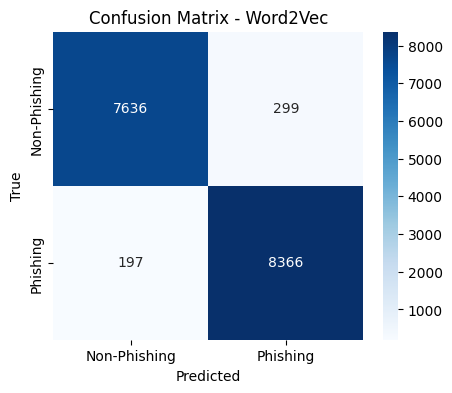

=== FastText ===
Accuracy: 0.9695114559340526
F1 Score: 0.9707948673285722
ROC-AUC: 0.9945688286403286

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      7935
           1       0.97      0.98      0.97      8563

    accuracy                           0.97     16498
   macro avg       0.97      0.97      0.97     16498
weighted avg       0.97      0.97      0.97     16498



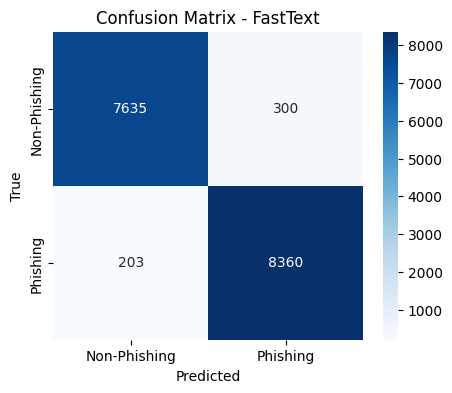

In [36]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Extrinsic Evaluation

def evaluate_model(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(f"=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Phishing','Phishing'], yticklabels=['Non-Phishing','Phishing'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()


# Evaluate both
evaluate_model(X_train_w2v, X_test_w2v, y_train, y_test, "Word2Vec")
evaluate_model(X_train_ft, X_test_ft, y_train, y_test, "FastText")

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

# === Intrinsic Evaluation for Word Embeddings ===
def intrinsic_evaluation(model, word_pairs):
    """
    Compute cosine similarity for given word pairs using trained embeddings.
    """
    print(f"\n=== Intrinsic Evaluation: {type(model).__name__} ===\n")
    for w1, w2 in word_pairs:
        if w1 in model.wv and w2 in model.wv:
            sim = cosine_similarity(
                [model.wv[w1]], [model.wv[w2]]
            )[0][0]
            print(f"Similarity({w1}, {w2}) = {sim:.4f}")
        else:
            print(f"One of the words ({w1}, {w2}) not in vocabulary.")

# Example word pairs (modify depending on dataset vocabulary)
word_pairs = [
    ("phishing", "fraud"),
    ("email", "message"),
    ("bank", "money"),
    ("login", "password"),
    ("safe", "dangerous")
]

# Run intrinsic evaluation for both models
intrinsic_evaluation(w2v_model, word_pairs)
intrinsic_evaluation(ft_model, word_pairs)



=== Intrinsic Evaluation: Word2Vec ===

Similarity(phishing, fraud) = 0.4578
Similarity(email, message) = 0.5866
Similarity(bank, money) = 0.6096
Similarity(login, password) = 0.6875
Similarity(safe, dangerous) = 0.3566

=== Intrinsic Evaluation: FastText ===

Similarity(phishing, fraud) = 0.5324
Similarity(email, message) = 0.6299
Similarity(bank, money) = 0.5597
Similarity(login, password) = 0.6993
Similarity(safe, dangerous) = 0.4462


## 13. Word Frequency Analysis
- Computes and displays word frequency distributions from the dataset.
- Helps understand dataset vocabulary and balance.

/tmp/ipython-input-3161565622.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


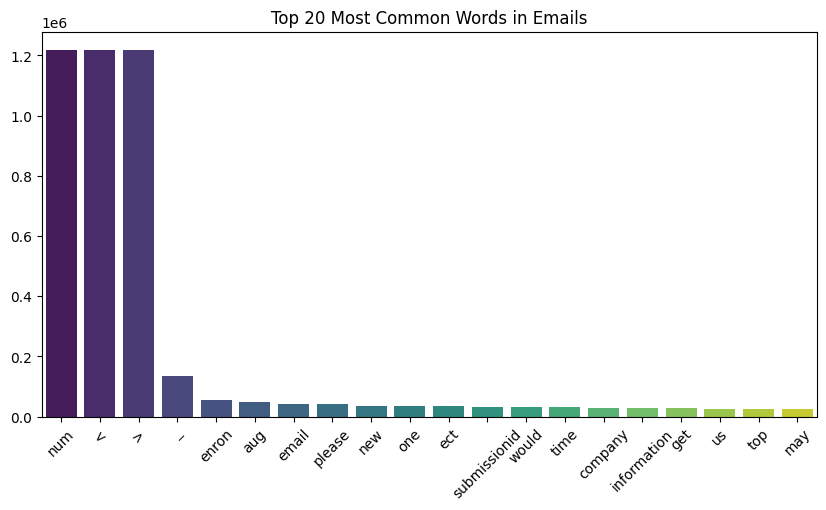

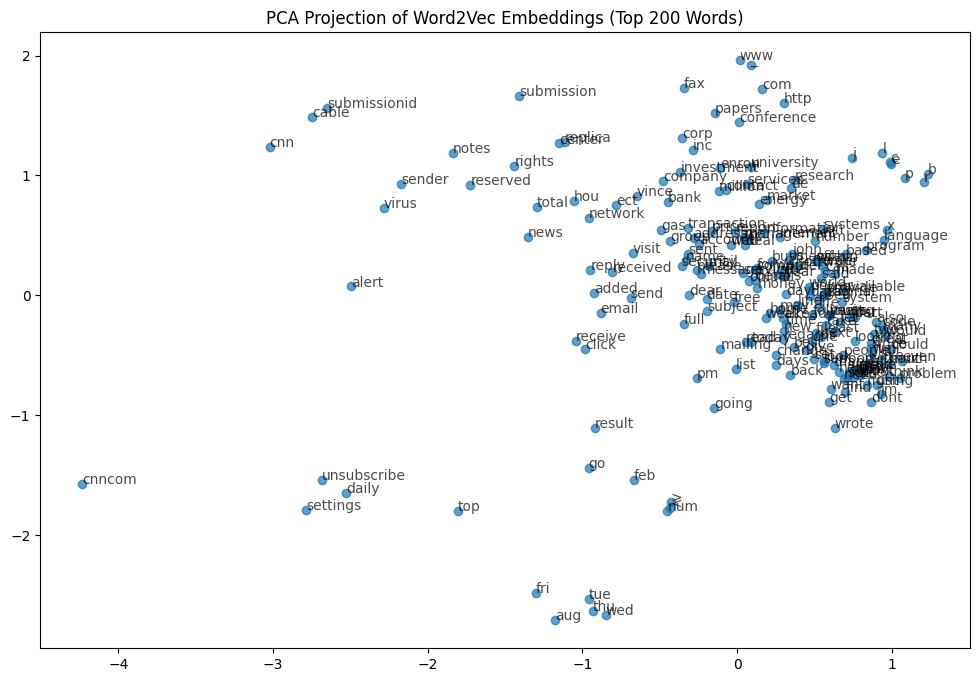

In [38]:
# Word frequency distribution
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

all_tokens = [w for sent in df['tokens'] for w in sent]
word_freq = Counter(all_tokens).most_common(20)

words, counts = zip(*word_freq)
plt.figure(figsize=(10,5))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title("Top 20 Most Common Words in Emails")
plt.xticks(rotation=45)
plt.show()


# Embedding visualization (Word2Vec)
from sklearn.decomposition import PCA
X_emb = w2v_model.wv[w2v_model.wv.key_to_index]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_emb[:200])


plt.figure(figsize=(12,8))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.7)
for i, word in enumerate(list(w2v_model.wv.key_to_index)[:200]):
    plt.annotate(word, (X_pca[i,0], X_pca[i,1]), alpha=0.7)
plt.title("PCA Projection of Word2Vec Embeddings (Top 200 Words)")
plt.show()

In [40]:
w2v_model.save(os.path.join(WORKDIR, 'word2vec.model'))
ft_model.save(os.path.join(WORKDIR, 'fasttext.model'))

# THANK YOU